# Deep learning for medical imaging

## Practicum 2: Computed Tomography Image Visualisation & Reconstruction
Sep-Oct 2025
==============================================================================================

In this practicum, you will work with several topics covered in the theory sessions. In particular you will (1) simulate a simple and more complex phantoms, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over a single slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms. In addition, the Shepp–Logan phantom will be used to analyse noise during reconstruction.

### Aims:
- Generate simple and complex phantoms
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

``Remember to comment your code and provide some discussion on the results obtained for each section.``

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon


### 2.1 Visualise a lung CT dicom image and create a phantom (2 points)

Open and visualise the Lung CT volume stored at the `LungCT-Diagnosis` folder. Read each of the indivdual `dcm` images, and display some 2D slices. Some basic image processing might be needed. Then, create a 3D phantom with the ribcages based on their HU and visualise the 3D rendering. Congratulations, you have created your first anthropomorphic phantom!

<img src='images_4_notebook/LungPhantomImage.png' width="400">


<img src='images_4_notebook/LungPhantomRendering.png' width="400">


Data was taken from https://www.cancerimagingarchive.net/collection/lungct-diagnosis/ 


In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdc
from pydicom.filereader import dcmread
from skimage.exposure import rescale_intensity
from skimage.morphology import ball, binary_opening, binary_closing, remove_small_objects
from skimage.measure import marching_cubes
from scipy.ndimage import gaussian_filter
import plotly.graph_objects as go 

SyntaxError: invalid syntax (926251898.py, line 1)

In [ ]:
# ---------- 1) Read DICOM series ----------
DATA_DIR = Path("LungCT-Diagnosis")  # set to your dataset root

def read_series(dicom_dir: Path):
    files = sorted([p for p in dicom_dir.rglob("*.dcm")]) # find all DICOMs
    assert files, f"No DICOMs under {dicom_dir}"        # make sure folder is not empty
    # read all headers to sort by position or instance
    metas = []  # list to store (file, z-position, instance number)
    for f in files:
        ds = dcmread(str(f), stop_before_pixels=True, force=True) # read header only
        z = None
        if hasattr(ds, "ImagePositionPatient"):                     # check if z-pos exists
            z = float(ds.ImagePositionPatient[2])
        inst = int(getattr(ds, "InstanceNumber", 0))                # fallback if missing
        metas.append((f, z, inst))                                  # store metadata
    # prefer ImagePositionPatient for sort, else InstanceNumber
    # sort slices: prefer z-position, else use instance number
    if all(m[1] is not None for m in metas):
        metas.sort(key=lambda x: x[1])
    else:
        metas.sort(key=lambda x: x[2])

    
    # insert your code here
    return metas

sorted_slices = read_series(DATA_DIR)  # Returns list of (file_path, z_position, instance_number) tuples sorted by slice position


In [4]:
# ---------- 2) 2D visualisation with window/level ----------

# insert your code here

# Load pixel data from sorted slices
ct_volume = np.stack([dcmread(str(f), force=True).pixel_array for f, _, _ in sorted_slices], axis=0)


# Apply basic lung window: level = -600 HU, width = 1500 HU
def window_image(volume, level=-200, width=1500):
    """Window CT volume using level/width"""
    min_val = level - width // 2
    max_val = level + width // 2
    volume = np.clip(volume, min_val, max_val)
    volume = (volume - min_val) / (max_val - min_val)  # normalize to [0,1]
    return volume

ct_windowed = window_image(ct_volume)

# Display middle slices with correct aspect ratio
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Get middle slice indices
axial_slice = ct_windowed.shape[0] // 2
coronal_slice = ct_windowed.shape[1] // 2
sagittal_slice = ct_windowed.shape[2] // 2

# Axial
axes[0].imshow(ct_windowed[ct_windowed.shape[0]//2], cmap="gray", aspect=ct_windowed.shape[2]/ct_windowed.shape[1])
axes[0].set_title(f"Axial\nz={axial_slice}, WL=-600, WW=1500")

# Coronal
axes[1].imshow(ct_windowed[:, ct_windowed.shape[1]//2, :].T, cmap="gray", origin="lower",
               aspect=ct_windowed.shape[0]/ct_windowed.shape[2])
axes[1].set_title(f"Coronal\nWL=-600, WW=1500")

# Sagittal
axes[2].imshow(ct_windowed[:, :, ct_windowed.shape[2]//2].T, cmap="gray", origin="lower",
               aspect=ct_windowed.shape[0]/ct_windowed.shape[1])
axes[2].set_title(f"Sagittal\nWL=-600, WW=1500")

for ax in axes:
    ax.axis("off")

plt.show()

NameError: name 'sorted_slices' is not defined



<span style="color: blue; "> *Above figure shows three orthogonal CT views with lung window settings (WL=-600, WW=1500)* </span>

In [ ]:
# ---------- Convert to Hounsfield Units (HU) ----------
def convert_to_hu(dicom_volume, sorted_metas):
    """
    Convert DICOM pixel values to Hounsfield Units using the formula:
    HU = 1000 * (μ - μ_water) / μ_water
    In practice: HU = slope * pixel_value + intercept
    """
    hu_volume = np.zeros_like(dicom_volume, dtype=np.float32)
    
    for i, (file_path, _, _) in enumerate(sorted_metas):
        ds = dcmread(str(file_path), force=True)
        pixel_data = dicom_volume[i]
        
        # Get rescale parameters (default to 1 and 0 if not present)
        slope = getattr(ds, 'RescaleSlope', 1.0)
        intercept = getattr(ds, 'RescaleIntercept', 0.0)
        
        # Convert to HU
        hu_volume[i] = pixel_data * slope + intercept
    
    return hu_volume

# Convert the volume to HU
ct_hu = convert_to_hu(ct_volume, sorted_slices)




<span style="color: blue; "> The histogram should be in this area. </span>

<img src='images_4_notebook/HU_scale.jpg' width="400">

In [5]:
# ---------- 3) Ribcage phantom via HU threshold ----------
# Bone typically has HU values > 300, but we'll use a conservative threshold
BONE_TH = 300.0

# Create bone mask
bone_mask = ct_hu > BONE_TH

# Apply morphological operations to clean up the mask
# Remove small objects that might be noise
bone_mask_cleaned = remove_small_objects(bone_mask, min_size=100)

# Visualize the bone mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(bone_mask_cleaned[bone_mask_cleaned.shape[0]//2], cmap="gray", 
               aspect=bone_mask_cleaned.shape[2]/bone_mask_cleaned.shape[1])
axes[0].set_title(f"Bone Mask (Axial)\nThreshold: {BONE_TH} HU")

# Coronal view
axes[1].imshow(bone_mask_cleaned[:, bone_mask_cleaned.shape[1]//2, :].T, cmap="gray", 
               origin="lower", aspect=bone_mask_cleaned.shape[0]/bone_mask_cleaned.shape[2])
axes[1].set_title(f"Bone Mask (Coronal)\nThreshold: {BONE_TH} HU")

# Sagittal view
axes[2].imshow(bone_mask_cleaned[:, :, bone_mask_cleaned.shape[2]//2].T, cmap="gray", 
               origin="lower", aspect=bone_mask_cleaned.shape[0]/bone_mask_cleaned.shape[1])
axes[2].set_title(f"Bone Mask (Sagittal)\nThreshold: {BONE_TH} HU")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'ct_hu' is not defined

In [6]:

# ---------- Optional: Histogram of HU values ----------
plt.figure(figsize=(10, 6))
plt.hist(ct_hu.flatten(), bins=200, range=(-1000, 2000), alpha=0.7, color='blue')
plt.axvline(x=BONE_TH, color='red', linestyle='--', label=f'Bone Threshold ({BONE_TH} HU)')
plt.axvline(x=-600, color='green', linestyle='--', label='Lung Window Level (-600 HU)')
plt.axvline(x=0, color='orange', linestyle='--', label='Water (0 HU)')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('Histogram of CT Volume HU Values')
plt.legend()
plt.yscale('log')  # Log scale to better see the distribution
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print(f"CT Volume HU Statistics:")
print(f"  Min HU: {ct_hu.min():.2f}")
print(f"  Max HU: {ct_hu.max():.2f}")
print(f"  Mean HU: {ct_hu.mean():.2f}")
print(f"  Std HU: {ct_hu.std():.2f}")
print(f"  Bone voxels: {np.sum(bone_mask_cleaned)} ({np.sum(bone_mask_cleaned) / bone_mask_cleaned.size * 100:.2f}%)")

NameError: name 'ct_hu' is not defined

<span style="color: blue; "> The histogram should be in this area. </span>

<img src='images_4_notebook/HU_scale.jpg' width="400">

In [7]:
# ---------- 4) 3D rendering with marching cubes ----------
# Marching cubes expects z-y-x ordering and voxel spacing.



# ---------- 4) 3D rendering with marching cubes ----------
# Assume bone_mask is your boolean bone mask (from Step 3)
# If your CT has spacing info, set it here (z, y, x)
# ---------- 4) 3D rendering with marching cubes ----------

def create_3d_mesh(volume, threshold, spacing=(1, 1, 1)):
    """
    Create a 3D mesh from a volume using marching cubes
    
    Parameters:
    - volume: 3D numpy array (z, y, x)
    - threshold: HU threshold for surface extraction
    - spacing: voxel spacing (z, y, x)
    - simplify: whether to reduce mesh complexity for better performance
    """
    try:
        # Apply Gaussian filter to smooth the volume (reduces noise in mesh)
        smoothed_volume = gaussian_filter(volume.astype(np.float32), sigma=1.0)
        
        # Use marching cubes to extract the surface
        verts, faces, normals, values = marching_cubes(
            smoothed_volume, 
            level=threshold,
            spacing=spacing,
            allow_degenerate=False
        )
        return verts, faces, normals, values
    
    except Exception as e:
        print(f"Error in mesh creation: {e}")
        return None, None, None, None

def plot_3d_mesh_plotly(verts, faces, title="3D Reconstruction", color='lightgray', opacity=0.8):
    """
    Create an interactive 3D plot using Plotly
    """

    fig = go.Figure(data=[go.Mesh3d(
        x=verts[:, 2],  # Plotly uses x, y, z convention
        y=verts[:, 1],  
        z=verts[:, 0],  # Note: swapping z and x for correct orientation
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=color,
        opacity=opacity,
        flatshading=True,
        lighting=dict(
            ambient=0.3,
            diffuse=0.8,
            fresnel=0.1,
            specular=0.5,
            roughness=0.1
        ),
        lightposition=dict(x=100, y=200, z=100)
    )])
    
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            font=dict(size=16)
        ),
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            aspectmode='data',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            bgcolor='rgb(240, 240, 240)'
        ),
        width=800,
        height=600,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    return fig

# Get voxel spacing from DICOM metadata (estimate if not available)
def get_voxel_spacing(sorted_metas):
    """Extract voxel spacing from DICOM headers"""
    try:
        # Get first slice to check spacing
        ds = dcmread(str(sorted_metas[0][0]), force=True)
        
        # Pixel spacing (x, y)
        if hasattr(ds, 'PixelSpacing'):
            pixel_spacing = [float(x) for x in ds.PixelSpacing]
        else:
            pixel_spacing = [1.0, 1.0]  # Default assumption
        
        # Slice thickness (z)
        if hasattr(ds, 'SliceThickness'):
            slice_thickness = float(ds.SliceThickness)
        else:
            # Estimate from z positions if available
            z_positions = [m[1] for m in sorted_metas if m[1] is not None]
            if len(z_positions) > 1:
                slice_thickness = abs(z_positions[1] - z_positions[0])
            else:
                slice_thickness = 1.0  # Default assumption
        
        spacing = (slice_thickness, pixel_spacing[0], pixel_spacing[1])
        print(f"Voxel spacing: {spacing} (z, y, x)")
        return spacing
    
    except Exception as e:
        print(f"Could not determine voxel spacing: {e}")
        return (1.0, 1.0, 1.0)  # Default isotropic spacing

# Get voxel spacing
voxel_spacing = get_voxel_spacing(sorted_slices)

# Create bone mask for 3D rendering (use a conservative threshold)
# For ribcage, we typically want > 300 HU, but you can adjust
bone_threshold_3d = 300.0
bone_mask_3d = ct_hu > bone_threshold_3d
bone_mask_3d = remove_small_objects(bone_mask_3d, min_size=100)

print(f"Bone mask stats: {np.sum(bone_mask_3d)} voxels ({np.sum(bone_mask_3d) / bone_mask_3d.size * 100:.2f}%)")

# Create the 3D mesh

verts, faces, normals, values = create_3d_mesh(
    bone_mask_3d.astype(np.float32), 
    threshold=0.5,  # For binary mask, use 0.5
    spacing=voxel_spacing
)

# Plot the 3D reconstruction
fig = plot_3d_mesh_plotly(
        verts, 
        faces, 
        title=f"3D Ribcage Reconstruction (Threshold: {bone_threshold_3d} HU)",
        color='lightblue',
        opacity=0.7
    )
fig.show()


#Try different thresholds for comparison
print("\nTrying different thresholds for comparison...")
thresholds_to_try = [150, 200, 400]

for thresh in thresholds_to_try:
    print(f"\n--- Testing threshold: {thresh} HU ---")
    bone_mask_temp = ct_hu > thresh
    bone_mask_temp = remove_small_objects(bone_mask_temp, min_size=100)
    
    verts_temp, faces_temp, _, _ = create_3d_mesh(
        bone_mask_temp.astype(np.float32),
        threshold=0.5,
        spacing=voxel_spacing,
    )
    
    if verts_temp is not None:
        fig_temp = plot_3d_mesh_plotly(
            verts_temp, 
            faces_temp, 
            title=f"3D Reconstruction ({thresh} HU)",
            color='lightgreen',
            opacity=0.6
        )
        fig_temp.show()
   


NameError: name 'sorted_slices' is not defined

### 2.2 Create a simple and homogeneous phantom (1.5 points)

Create a more simple 2D phantom which contains a fake lesion as shown below:

<img src='images_4_notebook/PhantomImage.png' width="400">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the synthetic lesion. Always remember to include the units of the axis when ploting a graph.

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

<Figure size 1000x600 with 0 Axes>

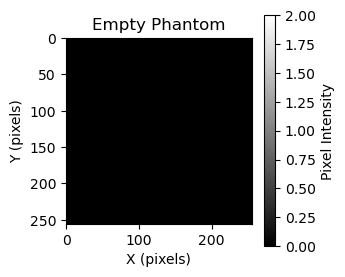

NameError: name 'create_circular_mask' is not defined

In [8]:
def show_phantom_2d(phantom, size=(3, 3), title="2D Phantom"):
    """
    Simple 2D visualization of the phantom
    """
    plt.figure(figsize=size)
    plt.imshow(phantom, cmap='gray', vmin=0, vmax=2)
    plt.colorbar(label='Pixel Intensity')
    plt.title(title)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.show()

# ---------- 2.2 Create Simple Homogeneous Phantom ----------

# Phantom parameters
phantom_size = 256  # 256 x 256 pixels
background_value = 0
tissue1_value = 1
tissue2_value = 2
tissue1_radius = 100  # pixels
tissue2_radius = 5    #pixels

# Create empty phantom (background) (2D array with background value(shape (256, 256)))
phantom = np.full((phantom_size, phantom_size), background_value, dtype=np.float32)
show_phantom_2d(phantom, title="Empty Phantom")

# Create Tissue 1 (large circle) - centered
center_phantom = (phantom_size // 2, phantom_size // 2)
tissue1_mask = create_circular_mask(phantom_size, phantom_size, 
                                   center=center_phantom, 
                                   radius=tissue1_radius)
phantom[tissue1_mask] = tissue1_value

show_phantom_2d(phantom, title="After Adding Tissue 1")

#create Tissue 2 (small circle) - offset
tissue2_center = (phantom_size // 2 + tissue1_radius//2, phantom_size // 2 + tissue1_radius//2)
tissue2_mask = create_circular_mask(phantom_size, phantom_size, 
                                   center=tissue2_center, 
                                   radius=tissue2_radius)
phantom[tissue2_mask] = tissue2_value

show_phantom_2d(phantom, title="After Adding Tissue 2")




### 2.3 Create the projections of the phantom (2 points)

Generate the projections of the previously generated 2D phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following approch:

Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.


``Questions``: How do the sinograms changes with number of projections? What is the effect of increasing/decrasing the number of projections? 

In [ ]:
def plot_sinogram(sinogram, title="Sinogram - every 5°"):
    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(phantom, cmap='gray', vmin=0, vmax=2)
    plt.title('Phantom')
    plt.xlabel('X (pixels)')  # Moved here for phantom
    plt.ylabel('Y (pixels)')  # Moved here for phantom
    plt.colorbar(label='Pixel Intensity')

    plt.subplot(1, 2, 2)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.title(title)
    plt.xlabel('Angle index')
    plt.ylabel('Detector position')
    plt.colorbar(label='Pixel Intensity')  # Only one colorbar needed

    plt.tight_layout()
    plt.show()
    
# Take projections at different angles 25 projections

# Create 25 equally spaced projection angles from 0° to 360° (excluding 360°)
theta = np.linspace(0, 360, 25, endpoint=False)

# Compute Radon transform (sinogram) by projecting phantom at each angle         
sinogram = radon(phantom, theta=theta)

# Visualize the phantom and its sinogram with descriptive title
plot_sinogram(sinogram , title = "Sinogram - 25 projections")


# Take projections at different angles 50 projections
theta_50 = np.linspace(0, 360, 50, endpoint=False)  
sinogram_50 = radon(phantom, theta=theta_50)

plot_sinogram(sinogram_50 , title = "Sinogram - 50 projections")

# Take projections at different angles 100 projections
theta_100 = np.linspace(0, 360, 100, endpoint=False)  
sinogram_100 = radon(phantom, theta=theta_100)

plot_sinogram(sinogram_100, title = "Sinogram - 100 projections")

# Take projections at different angles 200 projections
theta_200 = np.linspace(0, 360, 200, endpoint=False)  
sinogram_200 = radon(phantom, theta=theta_200)

plot_sinogram(sinogram_200 , title = "Sinogram - 200 projections")

IndentationError: unexpected indent (181113184.py, line 3)

``Questions``: How do the sinograms changes with number of projections? What is the effect of increasing/decrasing the number of projections? 

<span style="color: blue; "> As the number of projections increases, the sinogram becomes clearer and less blurry. The sinusoidal patterns representing the object appear smooth and continuous, closely approximating the true projection data. This improves the quality of the reconstructed image and reduces artifacts. 

<span style="color: blue; ">Conversely, with fewer projections, the sinogram looks sparse and discontinuous. 
The sinusoidal curves are jagged or broken, making it harder to capture the object’s details and leading to streaks or blurring in the reconstructed image. 
In this example, increasing the number of projections results in a smooth, continuous sinus pattern, while fewer projections produce a less continuous and more fragmented sinogram. </span>



### 2.4 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann). 

Make use of the ``matplotlib`` to show the original and reconstructed images of the phantom and compare the pixel intensity signal across the lesion profile (similarly to section 2.1).In addition, provide evaluation metric you could consider useful for this purpose (image difference, mean square error (MSE), peak signal to noise ratio (PSNR), structural index similarity (SSIM), etc.). Then, discuss the results.

In [ ]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def plot_reconstruction_comparison(original, reconstruction, title_suffix=""):
    """
    Plot original and reconstructed images side by side with quantitative metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Original image
    im1 = ax1.imshow(original, cmap='gray')
    ax1.set_title(f'Original Phantom {title_suffix}')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=ax1, label='Pixel Intensity')
    
    # Reconstructed image  
    im2 = ax2.imshow(reconstruction, cmap='gray')
    ax2.set_title(f'Reconstructed {title_suffix}')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=ax2, label='Pixel Intensity')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print evaluation metrics
    mse = mean_squared_error(original, reconstruction)
    
    # Calculate data range for PSNR and SSIM
    data_range = original.max() - original.min()
    
    psnr = peak_signal_noise_ratio(original, reconstruction, data_range=data_range)
    ssim = structural_similarity(original, reconstruction, data_range=data_range)
    
    print(f"--- Quantitative Evaluation Metrics {title_suffix} ---")
    print(f"MSE (Mean Squared Error): {mse:.4f}")
    print(f"PSNR (Peak Signal-to-Noise Ratio): {psnr:.2f} dB") 
    print(f"SSIM (Structural Similarity Index): {ssim:.4f}")

    

In [11]:
from skimage.transform import iradon, iradon_sart
'''reconstruction = iradon(
    sinogram,           # Your sinogram data (2D array)
    theta=angles,       # Projection angles used (array)
    filter_name='ramp', # Filter type (see below)
    circle=True,        # Assume object fits in circle
    interpolation='linear'  # How to interpolate
)'''

'''Available Filters:
filters = [
    'ramp',         # Default - sharpest, most noise
    'shepp-logan',  # Good balance (recommended)
    'cosine',       # Similar to shepp-logan  
    'hamming',      # More smoothing
    'hann'          # Most smoothing, least noise
]'''


# Interpretation guide
print(f"\nInterpretation:")
print(f"- MSE: Lower is better (0 = perfect)")
print(f"- PSNR: Higher is better (>30 dB = good, >40 dB = excellent)")
print(f"- SSIM: Closer to 1 is better (>0.9 = very similar)")


#100 projections - No Filter
reconstruction = iradon(sinogram_100, theta=theta_100)  # Perform filtered backprojection reconstruction 
plot_reconstruction_comparison(phantom, reconstruction, "100 projections - No Filter")# Compare original phantom with reconstructed image (unfiltered)

#200 projections - No Filter
reconstruction = iradon(sinogram_200, theta=theta_200)
plot_reconstruction_comparison(phantom, reconstruction, "200 projections - No Filter")

# Define parameters
projection_numbers = [100, 200]
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

# Generate sinograms for different projection numbers
sinograms = {}
for num_proj in projection_numbers:
    theta = np.linspace(0, 180, num_proj, endpoint=False)
    sinogram = radon(phantom, theta=theta, circle=True)
    sinograms[num_proj] = (sinogram, theta)

### Loop through all combinations of projection numbers and filters
for num_proj in projection_numbers:
    sinogram, theta = sinograms[num_proj]
    
    for filter_name in filters:
        # Reconstruct with current filter
        reconstruction = iradon(sinogram, theta=theta, filter_name=filter_name, circle=True)
        
        # Plot comparison
        plot_reconstruction_comparison(phantom, reconstruction, 
                                     f"{num_proj} projections - {filter_name.title()} Filter")
        




Interpretation:
- MSE: Lower is better (0 = perfect)
- PSNR: Higher is better (>30 dB = good, >40 dB = excellent)
- SSIM: Closer to 1 is better (>0.9 = very similar)


NameError: name 'plot_reconstruction_comparison' is not defined

<span style="color: blue; "> 200 projections with Shepp-Logan Filter provides the optimal balance between noise reduction, structural accuracy, and detail preservation for clinical CT reconstruction.

### 2.5 Sheep logan phantom (2 points)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis for the **noisy sinogram** for one case (approach, filter,...) using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms? 


<img src='images_4_notebook/SheepLoganPhantom.png' width="1000">



In order to create **noisy sinograms**, you can add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your noise-free sinograms (not to the image!) and reconstruct the phantom images with the different filters. Plot the reconstruction image and the (horizontal) intensity profile along specific row. Then, comment on the effects of the filters on the reconstructed phatom images.


In [ ]:
def plot_complete_analysis(phantom, sinogram, reconstruction, title_suffix=""):
    """
    Plot 4 panels: phantom, sinogram, reconstruction, and intensity profile
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Original Phantom
    im1 = axes[0].imshow(phantom, cmap='gray')
    axes[0].set_title(f'Original Phantom {title_suffix}')
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=axes[0], label='Pixel Intensity')
    
    # 2. Sinogram
    im2 = axes[1].imshow(sinogram, cmap='gray', aspect='auto')
    axes[1].set_title(f'Sinogram {title_suffix}')
    axes[1].set_xlabel('Projection Angle θ')
    axes[1].set_ylabel('Detector Position')
    plt.colorbar(im2, ax=axes[1], label='Projection Intensity')
    
    # 3. Reconstruction
    im3 = axes[2].imshow(reconstruction, cmap='gray')
    axes[2].set_title(f'Reconstruction {title_suffix}')
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    plt.colorbar(im3, ax=axes[2], label='Pixel Intensity')
    
    # 4. Intensity Profile (through middle row)
    profile_y = phantom.shape[0] // 2
    profile_original = phantom[profile_y, :]
    profile_recon = reconstruction[profile_y, :]
    x_positions = np.arange(phantom.shape[1])
    
    axes[3].plot(x_positions, profile_original, 'k-', linewidth=2, label='Original')
    axes[3].plot(x_positions, profile_recon, 'r--', linewidth=2, label='Reconstructed')
    axes[3].set_xlabel('X Position (pixels)')
    axes[3].set_ylabel('Pixel Intensity')
    axes[3].set_title(f'Intensity Profile (Y={profile_y})')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display metrics
    data_range = phantom.max() - phantom.min()
    mse = mean_squared_error(phantom, reconstruction)
    psnr = peak_signal_noise_ratio(phantom, reconstruction, data_range=data_range)
    ssim = structural_similarity(phantom, reconstruction, data_range=data_range)
    
    print(f"Metrics {title_suffix}:**")
    print(f"MSE: {mse:.4f} | PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")

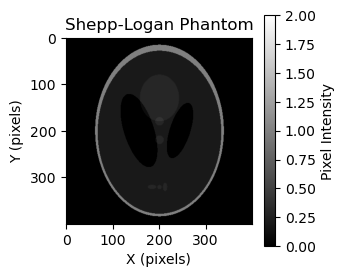

NameError: name 'plot_complete_analysis' is not defined

In [12]:
from skimage.data import shepp_logan_phantom

logan_phantom = shepp_logan_phantom()

show_phantom_2d(logan_phantom, title="Shepp-Logan Phantom")

sinogram_logan_200 = radon(logan_phantom, theta=theta_200)



# Set random seed for reproducible noise
np.random.seed(42)  # Any fixed number
# Add Poisson noise directly to phantom
lam = 10.0  # Poisson parameter
logan_phantom_noisy = np.random.poisson(sinogram_logan_200 * lam) / lam



reconstruction = iradon(logan_phantom_noisy, theta=theta_200)
plot_complete_analysis(logan_phantom, logan_phantom_noisy, reconstruction, 
                         f"200 projections - No Filter with Noise")
filters = [
    'ramp',         # Default - sharpest, most noise
    'shepp-logan',  # Good balance (recommended)
    'cosine',       # Similar to shepp-logan  
    'hamming',      # More smoothing
    'hann'          # Most smoothing, least noise
]

for filter_name in filters:
    # Reconstruct with current filter
    reconstruction = iradon(logan_phantom_noisy, theta=theta_200, filter_name=filter_name, circle=True)
    
    # Plot comparison
    plot_complete_analysis(logan_phantom, logan_phantom_noisy, reconstruction, 
                         f"200 projections - {filter_name.title()} Filter")


Comment on the effects of the filters on the reconstructed phatom images:

<span style="color: blue; ">Noisy Reconstruction Performance (200 projections)

| Filter | MSE | PSNR | SSIM | Performance |
|--------|-----|------|------|-------------|
| **No Filter** | 0.0106 | 19.74 dB | 0.3116 | Poor |
| **Ramp** | 0.0106 | 19.74 dB | 0.3116 | Poor |
| **Shepp-Logan** | 0.0075 | 21.25 dB | 0.3368 | Fair |
| **Cosine** | 0.0043 | 23.67 dB | 0.4164 | Good |
| **Hamming** | 0.0036 | 24.44 dB | 0.4785 | Very Good |
| **Hann** | 0.0035 | 24.58 dB | 0.5018 | Best |

**Performance Ranking:**
1. **Hann** - Best noise suppression and structural similarity
2. **Hamming** - Excellent noise reduction
3. **Cosine** - Good improvement over basic filters
4. **Shepp-Logan** - Moderate noise reduction
5. **Ramp/No Filter** - No noise suppression, poorest performance



### 2.6 Deep learning challenge (optional)
If you like this topic and want to explore deep learning (DL) approaches for CT image reconstruction, I encourage you to look at this **ICASSP-2024 3D-CBCT challenge** to advance the frontiers of DL for low-dose 3D cone-beam CT reconstruction at https://sites.google.com/view/icassp2024-spgc-3dcbct